# TIMIT performance analysis
This analyzes model performance on the full TIMIT corpus, with special attention to performance on vowels. There are no IPA reductions to a shared symbol set done here. These results should not be used in final presentations or results, as they include models that were actually trained on the TIMIT corpus. However, these serve as a sanity check for performance of all models on TIMIT. 

In [1]:
from collections import Counter, defaultdict
from pathlib import Path

import ipatok
import kaldialign
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

PALETTE = "gist_gray"
sns.color_palette(PALETTE)
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 200

In [2]:
GOLD_TRANSCRIPTIONS_CSV = Path("../../data/TIMIT Dataset/complete_ipa.csv")

TIMIT_EVAL_DIR = Path("../../data/timit_results/")
AGG_METRICS_CSV = TIMIT_EVAL_DIR / "aggregate_metrics" / "all_models_eval.csv"
FB_AGG_METRICS_CSV = TIMIT_EVAL_DIR / "aggregate_metrics" / "facebook_wav2vec2-espeak.csv"

DETAILED_PRED_DIR = TIMIT_EVAL_DIR / "detailed_predictions"
EDIT_DIST_DIR = TIMIT_EVAL_DIR / "edit_distances"

TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɹ̩", "ɚ"]
TIMIT_DIPHTHONGS = ["aʊ", "eɪ", "aɪ",  "oʊ", "ɔɪ"]

DIALECT_REGIONS = {
    "DR1": "DR1: New England",
    "DR2": "DR2: Northern",
    "DR3": "DR3: North Midland",
    "DR4": "DR4: South Midland",
    "DR5": "DR5: Southern",
    "DR6": "DR6: New York City",
    "DR7": "DR7: Western",
    "DR8": "DR8: Army Brat"
}


## Basic model performance comparisons
Show performance metrics for each model on TIMIT. 

In [3]:
# Manually define and join model source description
model_sources = [
    ("ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa", "Buckeye fine-tuned on full train split"),
    ("excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k", "Lee 2025 Wav2Vec2.0 TIMIT fine-tuned"),
    ("excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified", "Lee 2025 Wav2Vec2.0 TIMIT fine-tuned Simplified Phone Set"),
    ("ginic/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3", "Lee 2025 fine-tuned again on Buckeye"),
    ("openai_whisper-medium.en_to_epitran", "Whisper + Epitran"),
    ("facebook/wav2vec2-lv-60-espeak-cv-ft", "facebook/wav2vec2-lv-60-espeak-cv-ft"),
    ("facebook/wav2vec2-xlsr-53-espeak-cv-ft", "facebook/wav2vec2-xlsr-53-espeak-cv-ft"),
    ("allosaurus_eng2102_eng", "Allosaurus English"),
    ("ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns", "Taguchi et al. 2023"),
    # Intentionally omitting Whisper large - let's just keep the best in each category
    ("openai_whisper-large-v3-turbo_to_epitran", "Whisper + Epitran"),

]

hue_order = [t[1] for t in model_sources]

model_sources_df = pd.DataFrame(model_sources, columns=["model", "Model source"])


In [4]:
# Read in aggregate performance data
aggregate_perf_df = pd.concat([pd.read_csv(AGG_METRICS_CSV), pd.read_csv(FB_AGG_METRICS_CSV)])
aggregate_perf_df = pd.merge(aggregate_perf_df, model_sources_df, on="model").sort_values(by="mean_phone_error_rate")

display(aggregate_perf_df.head())


,model,mean_phone_error_rate,mean_phone_feature_error_rate,mean_feature_error_rate,substitutions,insertions,deletions,by_token_error_rates,Model source
5,excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k,0.110663,1.962235,0.182408,"{('ɨ', 'ʊ'): 31, ('ʒ', 'z'): 13, ('ɪ', 'ɛ'): 216, ('ɛ', 'ɨ'): 120, ('ɔ', 'o'): 22, ('ʌ', 'a'): 15, ('ə˞', 'ɚ'): 3823, ('ə', 'ɨ'): 737, ('ɾ̃', 'n'): 244, ('n', 'ŋ'): 99, ('ɑ', 'ɔ'): 346, ('ɹ', 'ɚ')...","{'k': 151, 'ʊ': 98, 'ɪ': 174, 'd': 171, 'ə̥': 70, 'l': 187, 'n': 200, 'ʔ': 513, 'ɨ': 260, 'ɛ': 21, 'w': 27, 'ɝ': 31, 'ɹ': 217, 'ɚ': 175, 'ə': 160, 'e': 15, 'v': 44, 'j': 105, 'h': 37, 't': 253, 'l...","{'l': 87, 'ɪ': 123, 't': 166, 'ʊ': 45, 'ə': 117, 'ɨ': 118, 'j': 35, 'ɹ': 81, 'ə̥': 38, 'ə˞': 56, 'm': 8, 'd': 74, 'n': 41, 'ʔ': 190, 'k': 27, 's': 22, 'v': 12, 'ʌ': 7, 'ɦ': 12, 'w': 14, 'ð': 19, '...","{'w': 0.006622516556291391, 'ɨ': 0.26158626046431344, 'd': 0.02886290121920876, 's': 0.027486652165315404, 'ʌ': 0.15196232339089483, 't': 0.0364766008618098, 'ʃ': 0.013608748481166465, 'n': 0.0389...",Lee 2025 Wav2Vec2.0 TIMIT fine-tuned
6,excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified,0.171306,2.138829,0.192588,"{('ɨ', 'ʊ'): 25, ('ɨ', 'ɪ'): 9539, ('ʉ', 'u'): 2304, ('ʒ', 'ʃ'): 184, ('ɾ̃', 'n'): 1272, ('ɪ', 'ɛ'): 160, ('ɛ', 'ɪ'): 246, ('ɔ', 'o'): 20, ('ʌ', 'a'): 12, ('ə˞', 'ɝ'): 4432, ('ə', 'ɪ'): 919, ('n',...","{'k': 162, 'ʊ': 83, 'ɪ': 636, 'd': 165, 'l': 164, 'n': 280, 'ə': 197, 'ʌ': 20, 'ʔ': 497, 'ɝ': 195, 'ɛ': 27, 'i': 114, 'm': 71, 'ʃ': 21, 's': 21, 'ɹ': 180, 'e': 18, 't': 237, 'v': 39, 'u': 85, 'h':...","{'l': 76, 'ɨ': 238, 't': 163, 'ʊ': 41, 'j': 24, 'ə̥': 39, 'd': 51, 'ɹ': 67, 'ə˞': 48, 'k': 33, 's': 20, 'ə': 101, 'ʔ': 132, 'ɪ': 64, 'ɦ': 21, 'w': 11, 'h': 38, 'ð': 9, 'ɜ˞': 14, 'ʃ': 6, 'ɛ': 20, '...","{'w': 0.005709065996802923, 'ɨ': 1.0, 'd': 0.02625031102264245, 's': 0.025509195175004943, 'ʌ': 0.14945054945054945, 't': 0.03998396632929151, 'ʃ': 0.010449574726609963, 'n': 0.0163026439544362, '...",Lee 2025 Wav2Vec2.0 TIMIT fine-tuned Simplified Phone Set
1,ginic/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3,0.234448,2.400496,0.175184,"{('ɨ', 'ʊ'): 127, ('ɨ', 'ɪ'): 6733, ('ʉ', 'u'): 2173, ('ʒ', 'z'): 18, ('l̩', 'ʊ'): 66, ('ɪ', 'ɛ'): 441, ('ɔ', 'o'): 201, ('ʌ', 'a'): 10, ('t', 'ʔ'): 967, ('ə˞', 'ɹ̩'): 3299, ('ə', 'ʊ'): 110, ('ə',...","{'l': 486, 'k': 93, 'ʊ': 197, 'ɪ': 707, 'ʃ': 286, 'd': 411, 'ʌ': 750, 'ɑ': 11, 's': 196, 'z': 165, 'n': 466, 'ɹ̩': 255, 'i': 83, 'ɹ': 458, 'e': 33, 'm': 179, 'w': 11, 't': 180, 'ɡ': 22, 'v': 72, '...","{'ɪ': 420, 'ʔ': 2860, 'w': 37, 'n': 168, 'f': 4, 'l': 52, 't': 504, 'ɜ˞': 57, 'ɨ': 527, 'k': 192, 'ə': 309, 'a': 10, 'ɡ': 19, 'ʊ': 85, 'o': 8, 'ə̥': 36, 'ɔ': 33, 'd': 115, 'ɹ': 77, 'ə˞': 59, 'h': ...","{'w': 0.01712719799040877, 'ɨ': 1.0, 'd': 0.05436675789997512, 's': 0.020071188451651175, 'ʌ': 0.07912087912087912, 't': 0.16855396332297826, 'ʃ': 0.011421628189550425, 'n': 0.06604660884104922, '...",Lee 2025 fine-tuned again on Buckeye
2,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,0.257570,2.696409,0.182567,"{('ɨ', 'ʊ'): 136, ('ɨ', 'ɪ'): 6875, ('ʉ', 'u'): 2051, ('ɪ', 'ɛ'): 475, ('ɔ', 'ɑ'): 311, ('ʌ', 'ɛ'): 64, ('ə˞', 'ɹ̩'): 3239, ('ə', 'ʊ'): 176, ('ə', 'ʌ'): 3327, ('ɾ̃', 'n'): 277, ('ə', 'æ'): 9, ('m'...","{'l': 414, 'k': 182, 't': 226, 'ɹ̩': 239, 'ʌ': 635, 'ɑ': 21, 'ʊ': 457, 's': 271, 'ɪ': 908, 'ɛ': 137, 'ʒ': 121, 'n': 392, 'd': 319, 'e': 72, 'ɹ': 411, 'ɾ': 32, 'i': 112, 'm': 172, 'w': 24, 'o': 62,...","{'ð': 20, 'a': 31, 'ɪ': 360, 'ʔ': 2833, 'ɑ': 67, 'w': 45, 'ɡ': 26, 'b': 25, 'ɨ': 669, 'n': 382, 'l': 156, 'ə̥': 79, 'ʉ': 30, 't': 596, 'ɾ': 13, 'i': 29, 'ɹ': 211, 'ʌ': 25, 'ə': 392, 'z': 37, 'ɜ˞':...","{'w': 0.027175154144781912, 'ɨ': 1.0, 'd': 0.09318238367753172, 's': 0.020763298398259838, 'ʌ': 0.10266875981161695, 't': 0.1998196212045295, 'ʃ': 0.020656136087484813, 'n': 0.10241404535479151, '...",Buckeye fine-tuned on full train split
7,facebook/wav2vec2-lv-60-espeak-cv-ft,0.319169,3.26615

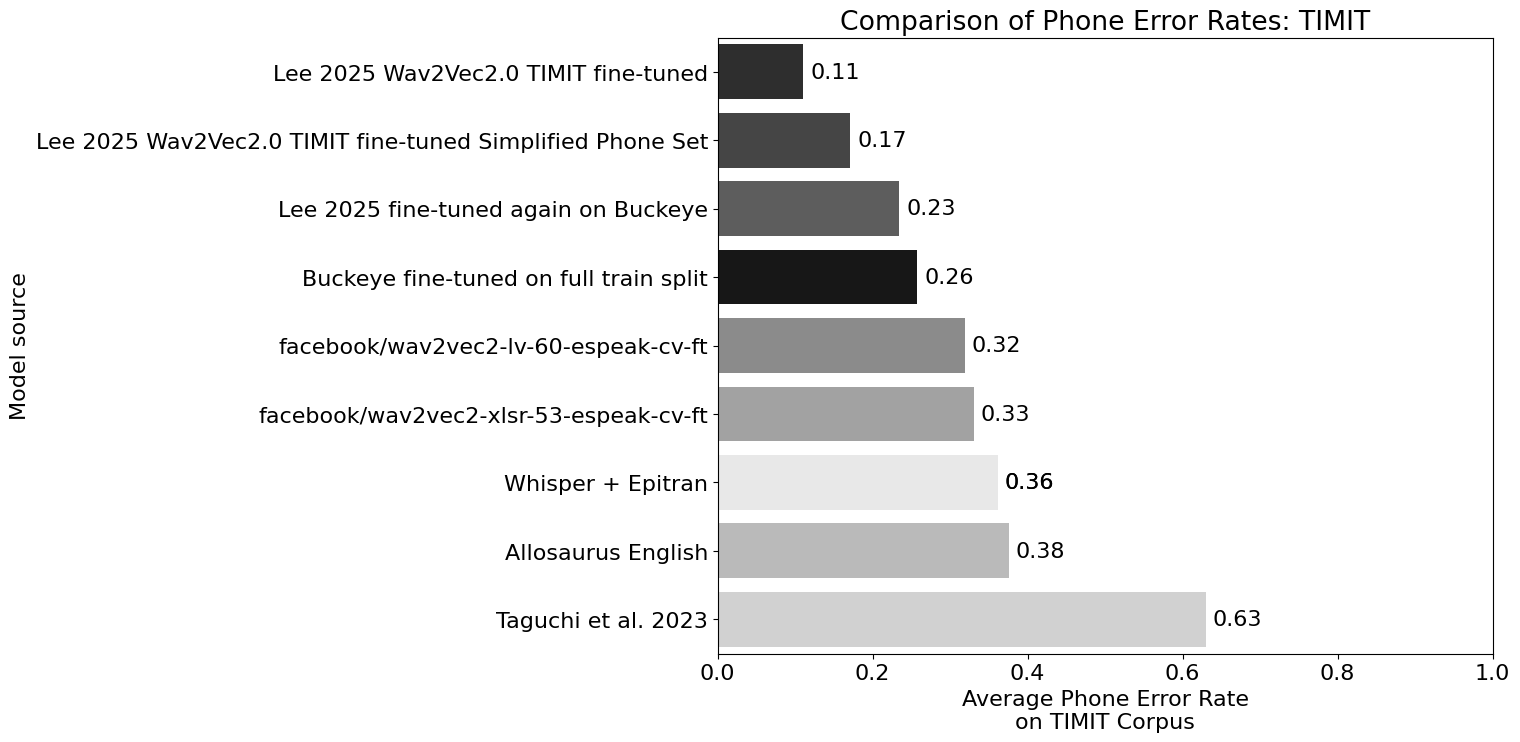

In [5]:
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=aggregate_perf_df, y="Model source", x="mean_phone_error_rate", hue="Model source", palette=PALETTE, hue_order=hue_order
)
g.set_title("Comparison of Phone Error Rates: TIMIT")
g.set_xlabel("Average Phone Error Rate\non TIMIT Corpus")
g.set_xlim((0,1))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)

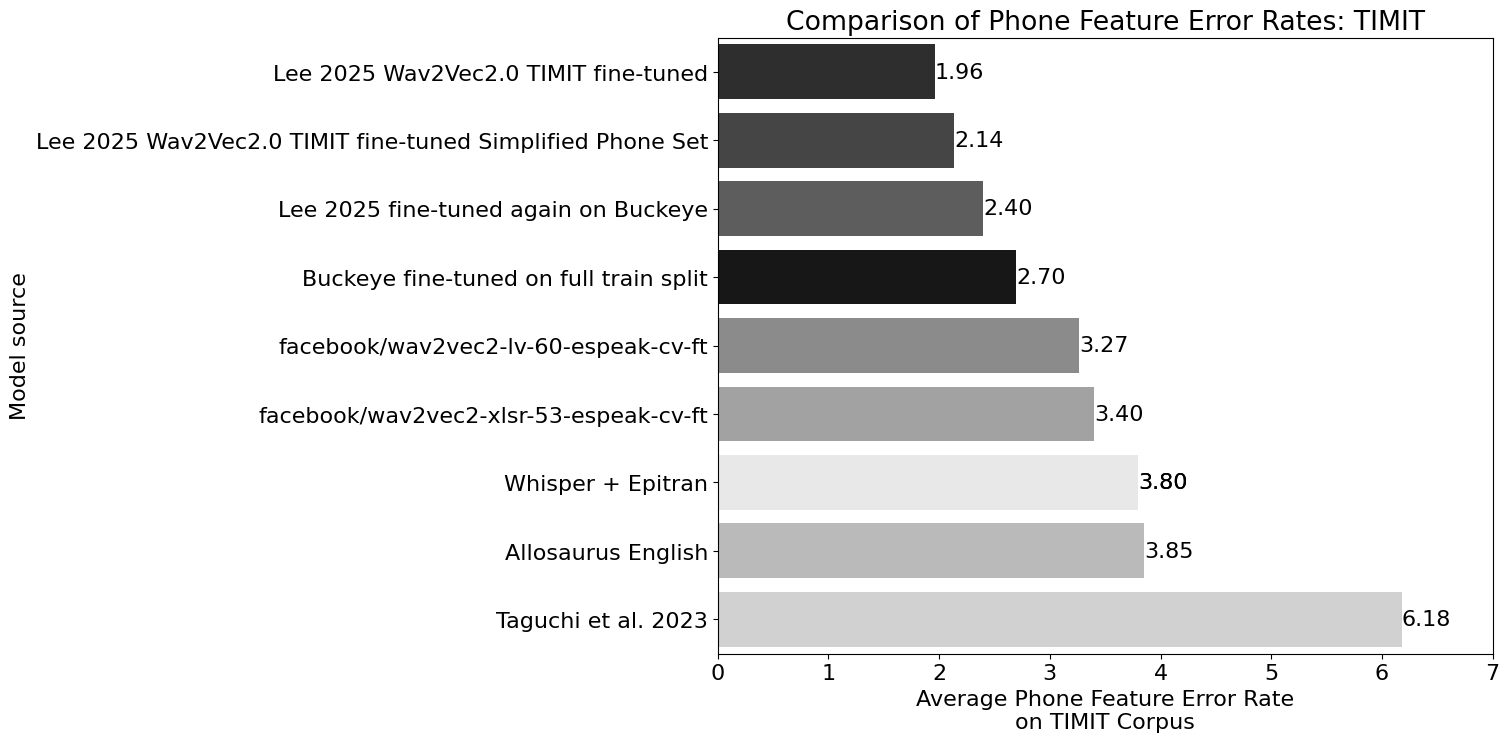

In [6]:
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=aggregate_perf_df,
    y="Model source",
    x="mean_phone_feature_error_rate",
    hue="Model source",
    palette=PALETTE,
    hue_order=hue_order,
)
g.set_title("Comparison of Phone Feature Error Rates: TIMIT")
g.set_xlabel("Average Phone Feature Error Rate\non TIMIT Corpus")

g.set_xlim((0, 7))

for bar in g.containers:
    g.bar_label(bar, fmt="%.2f")


In [7]:
# Let's look specifically at substitution errors
substitution_dfs = []
for (model, _) in model_sources:
    file_prefix = model.replace("/", "_")
    edit_dist_path = EDIT_DIST_DIR / f"{file_prefix}_substitutions.csv"
    edit_dist_df = pd.read_csv(edit_dist_path)
    edit_dist_df["model"] = model
    substitution_dfs.append(edit_dist_df)

full_substitution_df = pd.concat(substitution_dfs)
print(full_substitution_df.shape)
display(full_substitution_df.head())

(10495, 4)


,original,substitution,total_substitutions,model
0,ɨ,ɪ,6875,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
1,ə,ʌ,3327,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
2,ə˞,ɹ̩,3239,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
3,ɜ˞,ɹ̩,2126,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa
4,ʉ,u,2051,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa


Text(0.5, 0, 'Total Substitution Errors\non TIMIT Corpus')

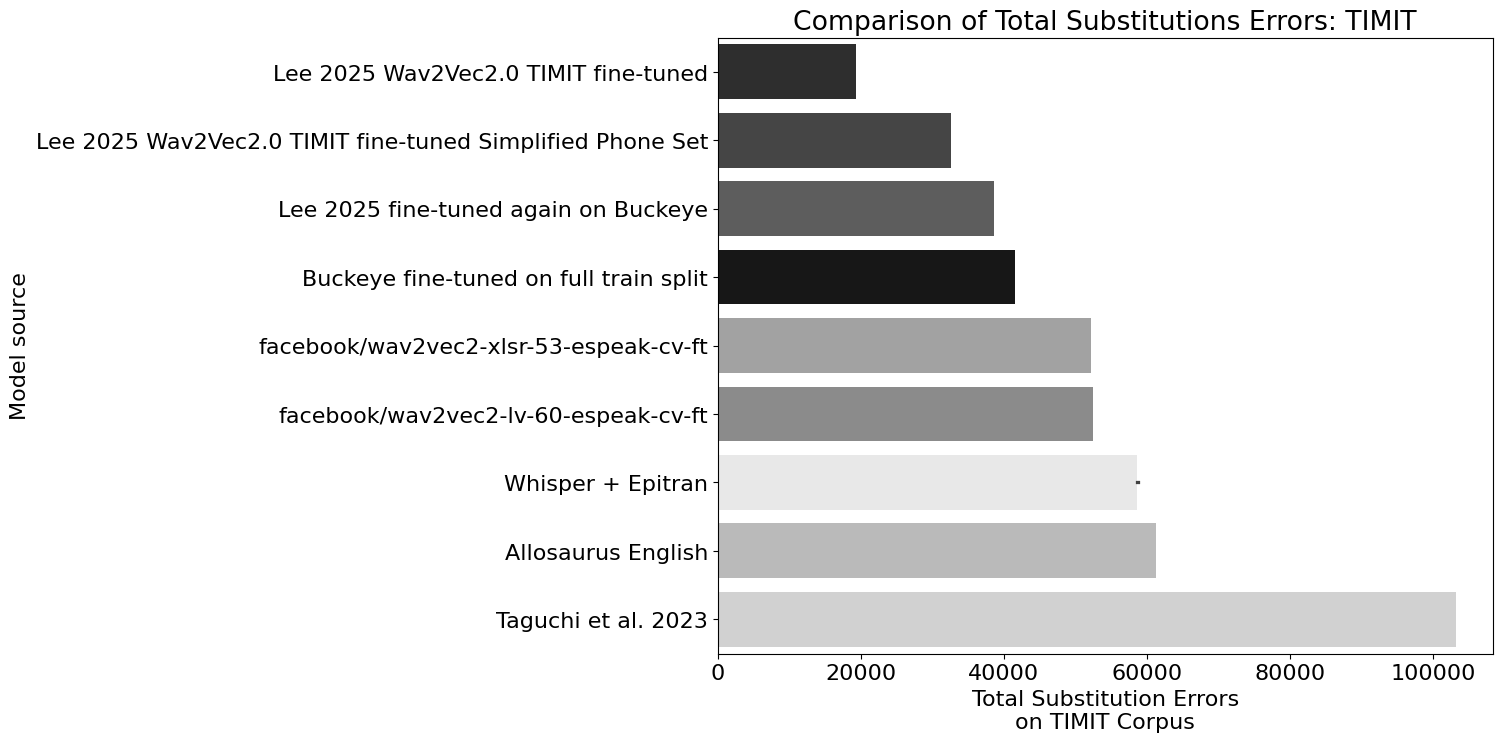

In [8]:
# Calculate total substitution errors for each model
subs_count_df = full_substitution_df.groupby("model")["total_substitutions"].sum().reset_index().sort_values(by="total_substitutions", ascending=True)
subs_count_df = pd.merge(subs_count_df, model_sources_df, on="model")
plt.figure(figsize=(10, 8))

g = sns.barplot(
    data=subs_count_df,
    y="Model source",
    x="total_substitutions",
    hue="Model source",
    palette=PALETTE,
    hue_order=hue_order,
)
g.set_title("Comparison of Total Substitutions Errors: TIMIT")
g.set_xlabel("Total Substitution Errors\non TIMIT Corpus")

# Dialect Region Performance Plots
This creates bar charts showing performance by dialect. Since the groupby and averaging was already done, we just need to read in the data and plot the results.

In [9]:
# Read in predictions and extract dialect region
detailed_results_dfs = []
for model, label in model_sources:
    clean_model_name = model.replace("/", "_")
    tmp_df = pd.read_csv(DETAILED_PRED_DIR / f"{clean_model_name}_detailed_predictions.csv")
    tmp_df["model_name"] = model
    tmp_df["Model source"] = label
    detailed_results_dfs.append(tmp_df)

detailed_preds_df = pd.concat(detailed_results_dfs)
detailed_preds_df["dialect"] = detailed_preds_df["filename"].apply(lambda x: x.split("/")[2].upper())
display(detailed_preds_df.head())


,filename,ipa,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,model_name,Model source,dialect
0,/complete/dr4/mmdm0/si681.wav,wɨdsʌtʃɨnæktɨvɹɨfjʉʒl̩bijʉsfl̩,wʊdsʌtʃɪnæktɪvɹɪfjuʒl̩bijusfl̩l,0.250000,1.500000,0.016369,{},{'l': 1},"{('ɨ', 'ʊ'): 1, ('ɨ', 'ɪ'): 3, ('ʉ', 'u'): 2}",ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR4
1,/complete/dr4/mmdm0/sa2.wav,doʊɾ̃æsmiɾɨkɪɹiɛɾ̃ɔliɹæɡlʌkðæt,doʊɾ̃æskmiɾɪkɛɹiɛɾ̃ɑliɹæɡlɛktðæt,0.214286,2.375000,0.265625,{},"{'k': 1, 't': 1}","{('ɨ', 'ɪ'): 1, ('ɪ', 'ɛ'): 1, ('ɔ', 'ɑ'): 1, ('ʌ', 'ɛ'): 1}",ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR4
2,/complete/dr4/mmdm0/sx411.wav,bʌɾə˞skɑtʃfʌdʒɡoʊzwɛlwəðvəɾ̃ɪləaɪskɹim,bʌɾɹ̩skɑtʃfʌdʒɡoʊzwɛlwʊvʌnɛlæskɹin,0.277778,3.666667,0.090856,"{'ð': 1, 'a': 1, 'ɪ': 1}",{},"{('ə˞', 'ɹ̩'): 1, ('ə', 'ʊ'): 1, ('ə', 'ʌ'): 1, ('ɾ̃', 'n'): 1, ('ɪ', 'ɛ'): 1, ('ə', 'æ'): 1, ('m', 'n'): 1}",ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR4
3,/complete/dr4/mmdm0/sa1.wav,ʃiædjə˞dɑɹksʉɾɨnɡɹiziwɔʃwɑɾə˞ɔljɪɹ,ʃiɛdjɹ̩dɑɹksuɾɪŋɡɹiziwɔʃwɔɾɹ̩ɑljɪɹ,0.250000,1.125000,0.036458,{},{},"{('æ', 'ɛ'): 1, ('ə˞', 'ɹ̩'): 2, ('ʉ', 'u'): 1, ('ɨ', 'ɪ'): 1, ('n', 'ŋ'): 1, ('ɑ', 'ɔ'): 1, ('ɔ', 'ɑ'): 1}",ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR4
4,/complete/dr4/mmdm0/sx231.wav,ʔɑʔɑɾ̃ə˞mɑmɑm,ʌɑɾ̃ɹ̩mɑmɑm,0.363636,2.250000,0.255682,"{'ʔ': 1, 'ɑ': 1}",{},"{('ʔ', 'ʌ'): 1, ('ə˞', 'ɹ̩'): 1}",ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR4


In [10]:
# Show performance by dialect region
dialect_df = detailed_preds_df.groupby(["model_name", "Model source", "dialect"])["phone_error_rates"].mean().reset_index()
display(dialect_df.head())
dialect_df = dialect_df.merge(pd.DataFrame(DIALECT_REGIONS.items(), columns=["dialect", "Dialect Region"]), on="dialect")
dialect_df =  dialect_df.sort_values(by=["Dialect Region", "phone_error_rates"], ascending=[True, True])
display(dialect_df)

,model_name,Model source,dialect,phone_error_rates
0,allosaurus_eng2102_eng,Allosaurus English,DR1,0.386781
1,allosaurus_eng2102_eng,Allosaurus English,DR2,0.366966
2,allosaurus_eng2102_eng,Allosaurus English,DR3,0.368755
3,allosaurus_eng2102_eng,Allosaurus English,DR4,0.381354
4,allosaurus_eng2102_eng,Allosaurus English,DR5,0.385897


,model_name,Model source,dialect,phone_error_rates,Dialect Region
2,excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned,DR1,0.109465,DR1: New England
3,excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified,Lee 2025 Wav2Vec2.0 TIMIT fine-tuned Simplified Phone Set,DR1,0.169599,DR1: New England
7,ginic/wav2vec2-large-lv60_phoneme-timit_english_timit-4k_buckeye-4k_bs32_3,Lee 2025 fine-tuned again on Buckeye,DR1,0.235077,DR1: New England
6,ginic/full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa,Buckeye fine-tuned on full train split,DR1,0.260780,DR1: New England
4,facebook/wav2vec2-lv-60-espeak-cv-ft,facebook/wav2vec2-lv-60-espeak-cv-ft,DR1,0.327954,DR1: New England
5,facebook/wav2vec2-xlsr-53-espeak-cv-ft,facebook/wav2vec2-xlsr-53-espeak-cv-ft,DR1,0.335719,DR1: New England
8,openai_whisper-large-v3-turbo_to_epitran,Whisper + Epitran,DR1,0.371775,DR1: New England
9,openai_whisper-medium.en_to_epitran,Whisper + Epitran,DR1,0.372344,DR1: New England
0,allosaurus_eng2102_eng,Allosaurus English,DR1,0.386781,DR1: New England
1,ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns,Taguchi et al. 2023,DR1,0.630873,DR1: New England


Text(0.5, 1.05, "Models' Average Phone Error Rates by Dialect Region")

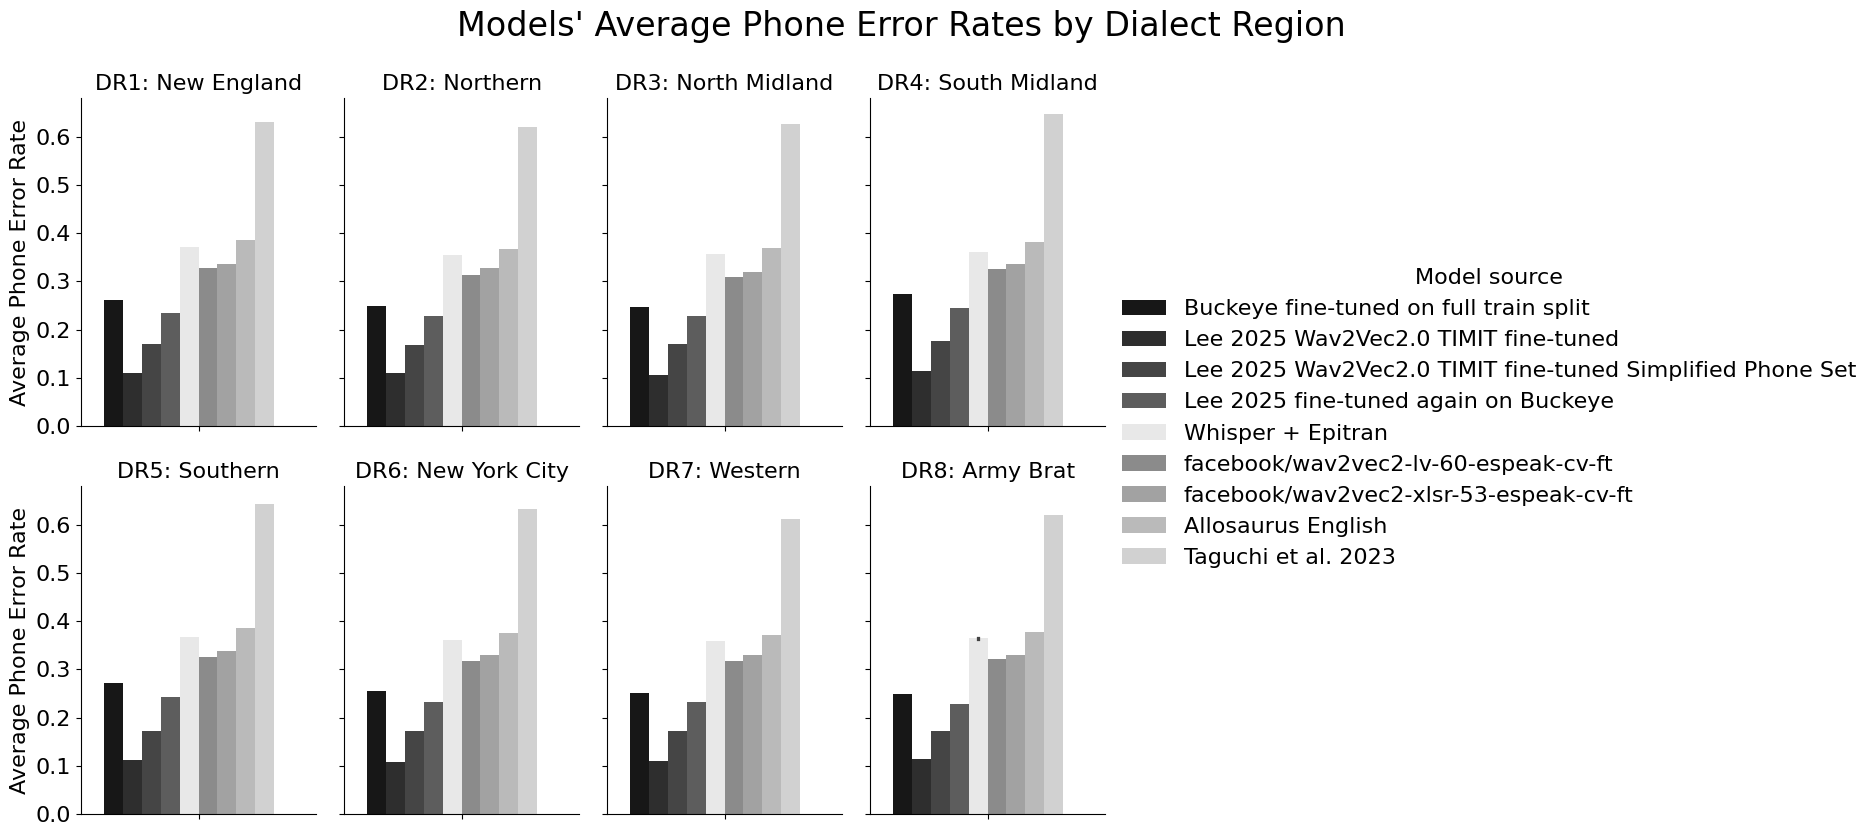

In [11]:
g = sns.FacetGrid(dialect_df, col="Dialect Region", col_wrap=4, height=4, aspect=0.75)
g.set_titles(col_template="{col_name}")
g.map_dataframe(sns.barplot, y="phone_error_rates", hue="Model source", palette=PALETTE, hue_order = hue_order)
g.add_legend(title="Model source")
g.set_ylabels("Average Phone Error Rate")
g.fig.suptitle("Models' Average Phone Error Rates by Dialect Region", fontsize=24, y=1.05)


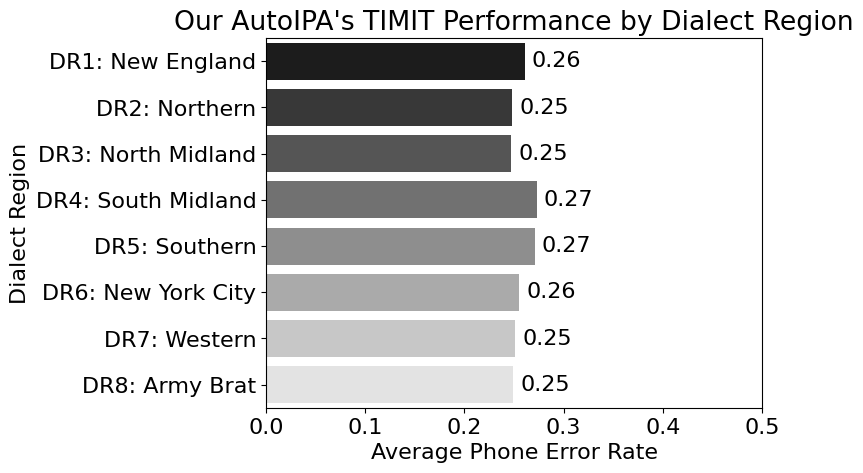

In [12]:
# Dialect performance for just our model"
our_model_dialect_df = dialect_df[dialect_df["Model source"] == "Buckeye fine-tuned on full train split"]
g = sns.barplot(data=our_model_dialect_df, y="Dialect Region", x="phone_error_rates", hue="Dialect Region", palette=PALETTE)
g.set_xlabel("Average Phone Error Rate")
g.set_xlim((0,0.5))
g.set(title="Our AutoIPA's TIMIT Performance by Dialect Region")
for bar in g.containers:
    g.bar_label(bar, fmt="%.2f", padding=5)


# Vowel Error Rate Analysis
How many instances of each vowel in the vocabulary are we getting wrong? 
$$ error\_rate(v) = \frac{count\_substitutions\_of(v) + count\_deletions(v)}{total\_count(v)}$$

In [13]:
gold_transcription_df = pd.read_csv(GOLD_TRANSCRIPTIONS_CSV)
gold_transcription_df["filename"] = gold_transcription_df["audio_filename"].str.lower()
gold_transcription_df["ipa_transcription"] = gold_transcription_df["ipa_transcription"].str.replace("ɝ", "ɹ̩")
vowel_counts = Counter()
for vowel in TIMIT_VOWELS + TIMIT_DIPHTHONGS:
    vowel_counts[vowel] += gold_transcription_df["ipa_transcription"].apply(lambda x: x.split().count(vowel)).sum()

vowel_counts

Counter({'ɨ': 11587,
         'i': 9663,
         'ɪ': 6760,
         'æ': 5404,
         'ɛ': 5293,
         'ə': 4956,
         'ɚ': 4790,
         'ɑ': 4197,
         'ɔ': 4096,
         'aɪ': 3242,
         'ʌ': 3185,
         'eɪ': 3088,
         'oʊ': 2913,
         'ɹ̩': 2846,
         'ʉ': 2488,
         'ɔɪ': 947,
         'aʊ': 945,
         'ʊ': 756,
         'u': 725,
         'ə̥': 493})

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_26650/3883285586.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")


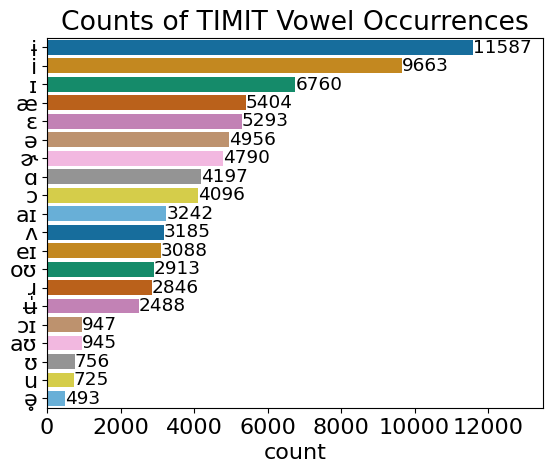

In [14]:
# Simple bar chart of vowel counts
plot_vowels, plot_counts = zip(*vowel_counts.most_common())
g = sns.barplot(y=plot_vowels, x=plot_counts, palette="colorblind")
g.set_xlim(0, 13500)
g.set_xlabel("count")
g.set(title="Counts of TIMIT Vowel Occurrences")
for bar in g.containers:
    g.bar_label(bar, fontsize='small')




In [15]:
EPS = "***"
def tally_edit_distance_errors(references, predictions):
    """Counts up edit distances from lists of already tokenized references and predictions."""
    subs = Counter()
    insertions = Counter()
    deletions = Counter()
    for ref_tokens, pred_tokens in zip(references, predictions):
        aligned_pairs = kaldialign.align(ref_tokens, pred_tokens, EPS)

        for r, p in aligned_pairs:
            if r == EPS:
                insertions[p] += 1
            elif p == EPS:
                deletions[r] += 1
            elif r != p:
                subs[(r, p)] += 1

    return subs, deletions, insertions

def diphthong_merge(t1, t2):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1+t2 in TIMIT_DIPHTHONGS:
        return True
    else:
        return False

In [16]:
# Re-do edit distance calculations with better tokenization, specifically turning
# on diphthong tokenization
our_model_detailed_preds_df = pd.read_csv(DETAILED_PRED_DIR / "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv").drop(columns=["substitutions", "insertions", "deletions"])
full_edit_distance_analysis_df = pd.merge(gold_transcription_df, our_model_detailed_preds_df, on="filename")

full_edit_distance_analysis_df["ipa_tokens"] = full_edit_distance_analysis_df["ipa_transcription"].str.split()
full_edit_distance_analysis_df["predicted_ipa_tokens"] = full_edit_distance_analysis_df["prediction"].apply(lambda x: ipatok.tokenise(x, diphthongs=True, merge=diphthong_merge))
print(full_edit_distance_analysis_df["ipa_tokens"][:10])
print(full_edit_distance_analysis_df["predicted_ipa_tokens"][:10])
display(full_edit_distance_analysis_df.head())


0                                                 [ʃ, i, ɦ, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ, ŋ, g, ɹ, i, s, i, w, ɑ, ʃ, w, ɑ, ɾ, ɹ̩, ʔ, ɔ, l, j, i, ɚ]
1                                                                     [d, oʊ, n, æ, s, m, i, t, ɨ, k, ɛ, ɹ, i, ɨ, n, ɔɪ, l, i, ɹ, æ, g, l, aɪ, k, ð, æ, t]
2    [h, ɪ, z, k, æ, p, t, ɨ, n, w, ə, s, θ, ɪ, n, æ, n, ɦ, æ, g, ɹ̩, d, ɨ, n, ɪ, z, b, j, ʉ, ɾ, ʉ, f, l̩, b, u, t, s, w, ɚ, w, ɔ, ɹ, n, ɨ, n, ʃ, æ, b, i]
3                                                                      [ð, ɨ, ɹ, i, z, ə, n, z, f, ɚ, ð, ɪ, s, d, aɪ, v, s, i, m, d, f, u, l, ɨ, ʃ, n, aʊ]
4                                                     [p, ɚ, d, ʌ, k, ʃ, ɨ, n, m, eɪ, f, ɔ, l, f, ɑ, ɹ, b, ə, l, oʊ, ə, k, s, p, ɨ, k, t, eɪ, ʃ, n̩, t, s]
5                                                       [p, i, t, s, ɚ, ɹ, i, ɨ, z, ɑ, ɹ, k, ɨ, n, v, i, n, j, ɨ, n, t, f, ɹ̩, ɨ, k, w, ɪ, k, l, ʌ, n, tʃ]
6                                                                     

,audio_filename,ipa_transcription,filename,ipa,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,ipa_tokens,predicted_ipa_tokens
0,/COMPLETE/DR1/FAKS0/SA1.wav,ʃ i ɦ æ d j ɹ̩ d ɑ ɹ k s u ɾ ɪ ŋ g ɹ i s i w ɑ ʃ w ɑ ɾ ɹ̩ ʔ ɔ l j i ɚ,/complete/dr1/faks0/sa1.wav,ʃiɦædjɜ˞dɑɹksuɾɪŋɡɹisiwɑʃwɑɾɜ˞ʔɔljiə˞,ʃihædjɹ̩dɑɹksuɾɪnɡɹissiwɑʃwɔɾɹ̩ɔljiɹ,0.235294,2.958333,0.143382,"[ʃ, i, ɦ, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ, ŋ, g, ɹ, i, s, i, w, ɑ, ʃ, w, ɑ, ɾ, ɹ̩, ʔ, ɔ, l, j, i, ɚ]","[ʃ, i, h, æ, d, j, ɹ̩, d, ɑ, ɹ, k, s, u, ɾ, ɪ, n, ɡ, ɹ, i, s, s, i, w, ɑ, ʃ, w, ɔ, ɾ, ɹ̩, ɔ, l, j, i, ɹ]"
1,/COMPLETE/DR1/FAKS0/SA2.wav,d oʊ n æ s m i t ɨ k ɛ ɹ i ɨ n ɔɪ l i ɹ æ g l aɪ k ð æ t,/complete/dr1/faks0/sa2.wav,doʊnæsmitɨkɛɹiɨnɔɪliɹæɡlaɪkðæt,doʊnæskmitɪkæɹiɪnɔɪliɹɛɡlaɪkðæʔ,0.200000,1.583333,0.220139,"[d, oʊ, n, æ, s, m, i, t, ɨ, k, ɛ, ɹ, i, ɨ, n, ɔɪ, l, i, ɹ, æ, g, l, aɪ, k, ð, æ, t]","[d, oʊ, n, æ, s, k, m, i, t, ɪ, k, æ, ɹ, i, ɪ, n, ɔɪ, l, i, ɹ, ɛ, ɡ, l, aɪ, k, ð, æ, ʔ]"
2,/COMPLETE/DR1/FAKS0/SI1573.wav,h ɪ z k æ p t ɨ n w ə s θ ɪ n æ n ɦ æ g ɹ̩ d ɨ n ɪ z b j ʉ ɾ ʉ f l̩ b u t s w ɚ w ɔ ɹ n ɨ n ʃ æ b i,/complete/dr1/faks0/si1573.wav,hɪzkæptɨnwəsθɪnænɦæɡɜ˞dɨnɪzbjʉɾʉfl̩butswə˞wɔɹnɨnʃæbi,hɪzkæptʌnwʌzsθɪnɛnhæɡɹ̩dɛnɪzbjuɾʌfl̩butswɹ̩wɔɹnɛntʃæbi,0.244898,3.083333,0.295068,"[h, ɪ, z, k, æ, p, t, ɨ, n, w, ə, s, θ, ɪ, n, æ, n, ɦ, æ, g, ɹ̩, d, ɨ, n, ɪ, z, b, j, ʉ, ɾ, ʉ, f, l̩, b, u, t, s, w, ɚ, w, ɔ, ɹ, n, ɨ, n, ʃ, æ, b, i]","[h, ɪ, z, k, æ, p, t, ʌ, n, w, ʌ, z, s, θ, ɪ, n, ɛ, n, h, æ, ɡ, ɹ̩, d, ɛ, n, ɪ, z, b, j, u, ɾ, ʌ, f, l̩, b, u, t, s, w, ɹ̩, w, ɔ, ɹ, n, ɛ, n, t, ʃ, æ, b, i]"
3,/COMPLETE/DR1/FAKS0/SI2203.wav,ð ɨ ɹ i z ə n z f ɚ ð ɪ s d aɪ v s i m d f u l ɨ ʃ n aʊ,/complete/dr1/faks0/si2203.wav,ðɨɹizənzfə˞ðɪsdaɪvsimdfulɨʃnaʊ,ðʌɹizʌn̩zfɹ̩ðɪstaɪvsimdfulɪʃnaʊ,0.206897,0.416667,0.277299,"[ð, ɨ, ɹ, i, z, ə, n, z, f, ɚ, ð, ɪ, s, d, aɪ, v, s, i, m, d, f, u, l, ɨ, ʃ, n, aʊ]","[ð, ʌ, ɹ, i, z, ʌ, n̩, z, f, ɹ̩, ð, ɪ, s, t, aɪ, v, s, i, m, d, f, u, l, ɪ, ʃ, n, aʊ]"
4,/COMPLETE/DR1/FAKS0/SI943.wav,p ɚ d ʌ k ʃ ɨ n m eɪ f ɔ l f ɑ ɹ b ə l oʊ ə k s p ɨ k t eɪ ʃ n̩ t s,/complete/dr1/faks0/si943.wav,pə˞dʌkʃɨnmeɪfɔlfɑɹbəloʊəkspɨkteɪʃn̩ts,pɹʌdʌkʃʌnmeɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃʌns,0.228571,2.125000,0.183333,"[p, ɚ, d, ʌ, k, ʃ, ɨ, n, m, eɪ, f, ɔ, l, f, ɑ, ɹ, b, ə, l, oʊ, ə, k, s, p, ɨ, k, t, eɪ, ʃ, n̩, t, s]","[p, ɹ, ʌ, d, ʌ, k, ʃ, ʌ, n, m, eɪ, f, ɔ, l, f, ɑ, ɹ, b, l̩, l, oʊ, ɛ, k, s, p, ɛ, k, t, eɪ, ʃ, ʌ, n, s]"


In [17]:
sub_counter, del_counter, inserts_counter = tally_edit_distance_errors(full_edit_distance_analysis_df["ipa_tokens"], full_edit_distance_analysis_df["predicted_ipa_tokens"])


In [18]:
# Get subs and deletions in good format for analysis
detailed_error_counts = defaultdict(Counter)
subs_counts = Counter()
for (sub_tuple, count) in sub_counter.items():
    subs_counts[sub_tuple[0]] += count
    detailed_error_counts[sub_tuple[0]][sub_tuple[1]] += count

print("Substitution Counts:", subs_counts)

for (deleted, count) in del_counter.items():
    detailed_error_counts[deleted]["<deleted>"] += count

print("Detailed Error Counts:", detailed_error_counts)

Substitution Counts: Counter({'ɨ': 10953, 'ɚ': 4683, 'ə': 4590, 'g': 2951, 'ʉ': 2463, 'dʒ': 1555, 'ɦ': 1479, 't': 1386, 'ɪ': 1335, 'ʔ': 1204, 'tʃ': 1066, 'z': 898, 'ɔ': 712, 'æ': 672, 'n': 668, 'i': 622, 'ɑ': 565, 'ɹ̩': 556, 'ɛ': 540, 'd': 455, 'n̩': 442, 'ə̥': 422, 'l̩': 360, 'ɾ̃': 347, 'ð': 301, 'ʌ': 297, 'ɾ': 288, 'aɪ': 264, 'oʊ': 245, 'ɹ': 237, 'ʊ': 236, 'eɪ': 194, 's': 179, 'ɔɪ': 168, 'v': 160, 'm̩': 132, 'dH': 116, 'l': 101, 'b': 91, 'j': 90, 'θ': 75, 'aʊ': 72, 'm': 71, 'ŋ': 67, 'w': 67, 'p': 53, 'u': 48, 'h': 45, 'ʃ': 43, 'ŋ̍': 43, 'ʒ': 40, 'f': 37, 'k': 36, 'tH': 14, 'ɡ': 2})
Detailed Error Counts: defaultdict(<class 'collections.Counter'>, {'ɦ': Counter({'h': 1410, '<deleted>': 44, 'ɪ': 11, 'ʌ': 10, 'ɾ': 6, 'l': 6, 'ɛ': 6, 'ɹ': 5, 'ʒ': 4, 'ɹ̩': 4, 'æ': 3, 'i': 2, 'd': 2, 'n': 2, 'k': 1, 'j': 1, 'z': 1, 'n̩': 1, 'u': 1, 'eɪ': 1, 'ŋ': 1, 'ʃ': 1}), 'ŋ': Counter({'n': 43, '<deleted>': 13, 'ɡ': 7, 'm': 5, 'ɪ': 5, 'k': 2, 'ʌ': 1, 'ɑ': 1, 'æ': 1, 'f': 1, 'ɾ̃': 1}), 'g': Counter({'ɡ':

In [19]:
# Compute vowel error rates
vowel_error_rates = {}
for v in TIMIT_VOWELS + TIMIT_DIPHTHONGS:
    subs_count = subs_counts[v]
    dels_count = del_counter[v]
    ver = (subs_count + dels_count)/ (vowel_counts[v])
    vowel_error_rates[v] = ver

ver_df = pd.DataFrame(vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]). sort_values(by="Vowel Error Rate", ascending=False)
error_ordering = ver_df[ver_df["Vowel Error Rate"] > 0]["Vowel"].tolist()
print("In descending frequency of errors:", error_ordering)

display(ver_df)


In descending frequency of errors: ['ə̥', 'ɚ', 'ɨ', 'ʉ', 'ə', 'ʊ', 'ɔɪ', 'ɪ', 'ɹ̩', 'ɔ', 'ɑ', 'æ', 'ɛ', 'ʌ', 'oʊ', 'aɪ', 'aʊ', 'u', 'eɪ', 'i']


,Vowel,Vowel Error Rate
10,ə̥,1.000000
14,ɚ,1.000000
12,ɨ,1.000000
11,ʉ,1.000000
9,ə,1.000000
7,ʊ,0.325397
19,ɔɪ,0.212249
5,ɪ,0.206213
13,ɹ̩,0.201335
3,ɔ,0.190430


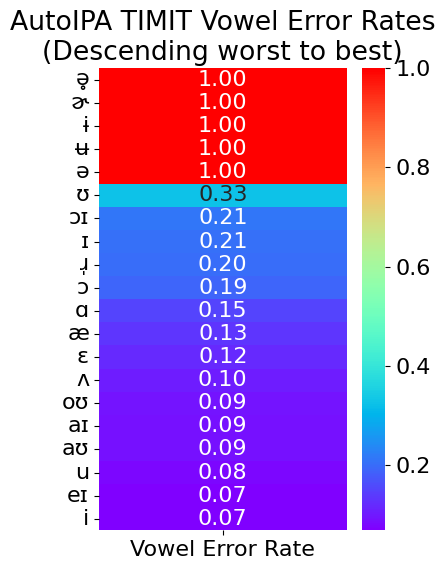

In [20]:
plt.figure(figsize=(4, 6))
sns.heatmap(
    ver_df.sort_values(by="Vowel Error Rate", ascending=False).set_index("Vowel"),
    cmap="rainbow",
    # cmap="spring_r",
    annot=True,
    fmt=".2f",
    yticklabels=True,
    # linewidths=1,
)
plt.title("AutoIPA TIMIT Vowel Error Rates\n(Descending worst to best)")
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("")
plt.show()


In [21]:
interesting_vowels = ver_df[ver_df["Vowel Error Rate"] > 0.0]["Vowel"].tolist()
print(interesting_vowels)


interesting_errors = []
for v in interesting_vowels:
    for error, count in detailed_error_counts[v].items():
        interesting_errors.append((v, error, count))

interesting_errors_df = pd.DataFrame(interesting_errors, columns=["Vowel", "Error", "Count"])
interesting_errors_df["Ratio of Vowel's Errors"] = interesting_errors_df.groupby("Vowel", group_keys=False)["Count"].apply(lambda x: x / x.sum())
display(interesting_errors_df)


['ə̥', 'ɚ', 'ɨ', 'ʉ', 'ə', 'ʊ', 'ɔɪ', 'ɪ', 'ɹ̩', 'ɔ', 'ɑ', 'æ', 'ɛ', 'ʌ', 'oʊ', 'aɪ', 'aʊ', 'u', 'eɪ', 'i']


,Vowel,Error,Count,Ratio of Vowel's Errors
0,ə̥,ʌ,129,0.261663
1,ə̥,ɪ,163,0.330629
2,ə̥,u,16,0.032454
3,ə̥,t,20,0.040568
4,ə̥,s,3,0.006085
5,ə̥,ʃ,9,0.018256
6,ə̥,ð,4,0.008114
7,ə̥,i,11,0.022312
8,ə̥,w,1,0.002028
9,ə̥,ʊ,5,0.010142


In [22]:
# Grab top ten errors for each vowel
top_errors_df = interesting_errors_df.groupby("Vowel").apply(lambda x: x.nlargest(5, "Count")).reset_index(drop=True)
top_errors_df["Vowel"] = pd.Categorical(top_errors_df["Vowel"], categories=error_ordering, ordered=True)
top_errors_df = top_errors_df.sort_values(by=["Vowel", "Count"], ascending=[True, False])
display(top_errors_df.head(20))

,Vowel,Error,Count,Ratio of Vowel's Errors
55,ə̥,ɪ,163,0.330629
56,ə̥,ʌ,129,0.261663
57,ə̥,<deleted>,71,0.144016
58,ə̥,ʒ,31,0.062880
59,ə̥,t,20,0.040568
60,ɚ,ɹ̩,3017,0.629854
61,ɚ,ɹ,862,0.179958
62,ɚ,ʌ,162,0.033820
63,ɚ,ʒ,134,0.027975
64,ɚ,ʃ,109,0.022756


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_26650/347233738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)


Text(0.5, 1.05, 'Top 5 errors for vowels Wav2IPA always incorrectly transcribes')

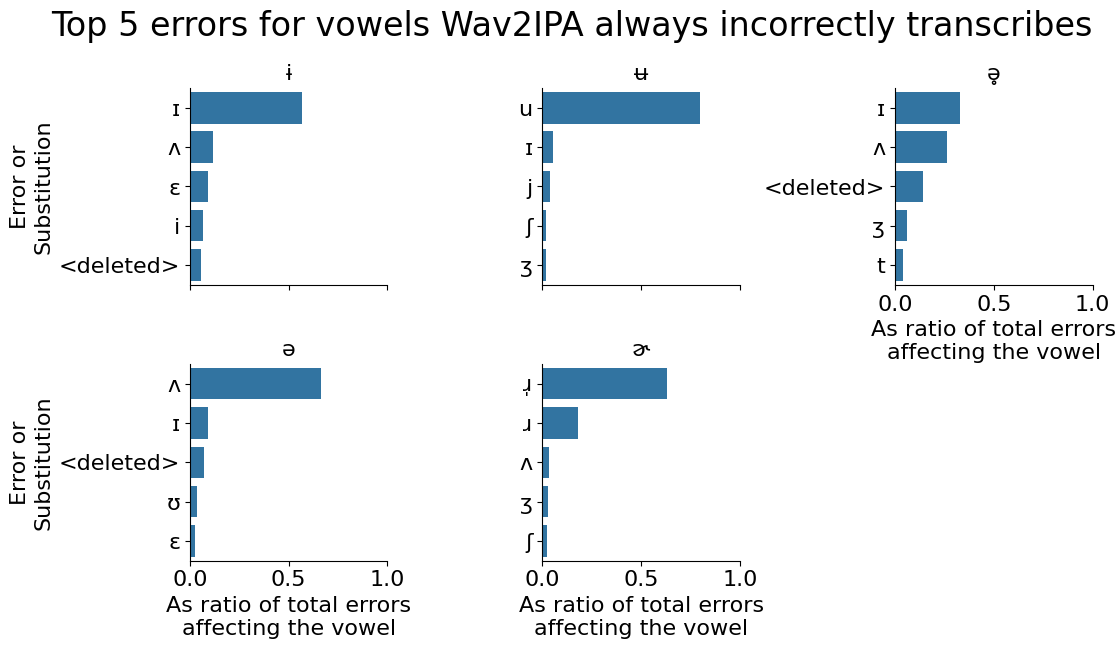

In [23]:
convention_errors = ["ɨ", "ʉ", "ə̥", "ə", "ɚ"]

convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(convention_errors)]
convention_errors_df["Vowel"] = pd.Categorical(convention_errors_df["Vowel"], categories=convention_errors, ordered=True)
g = sns.FacetGrid(convention_errors_df, col="Vowel", col_wrap=3, sharey=False, xlim=(0, 1), aspect=1.25)
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}")
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Top 5 errors for vowels Wav2IPA always incorrectly transcribes", fontsize=24, y=1.05)


['ʊ', 'ɔɪ', 'ɪ', 'ɹ̩', 'ɔ', 'ɑ', 'æ', 'ɛ', 'ʌ', 'oʊ', 'aɪ', 'aʊ', 'u', 'eɪ', 'i']


/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_26650/2687070040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_convention_errors_df["Vowel"] = pd.Categorical(


,Vowel,Error,Count,Ratio of Vowel's Errors
90,ʊ,ʌ,75,0.304878
91,ʊ,u,31,0.126016
92,ʊ,ɪ,30,0.121951
93,ʊ,oʊ,22,0.089431
94,ʊ,l̩,14,0.056911
45,ɔɪ,oʊ,57,0.283582
46,ɔɪ,ɔ,50,0.248756
47,ɔɪ,<deleted>,33,0.164179
48,ɔɪ,ɹ,14,0.069652
49,ɔɪ,ʌ,9,0.044776


Text(0.5, 1.05, 'Remaining TIMIT Vowels: Top 5 Wav2IPA Errors for each vowel')

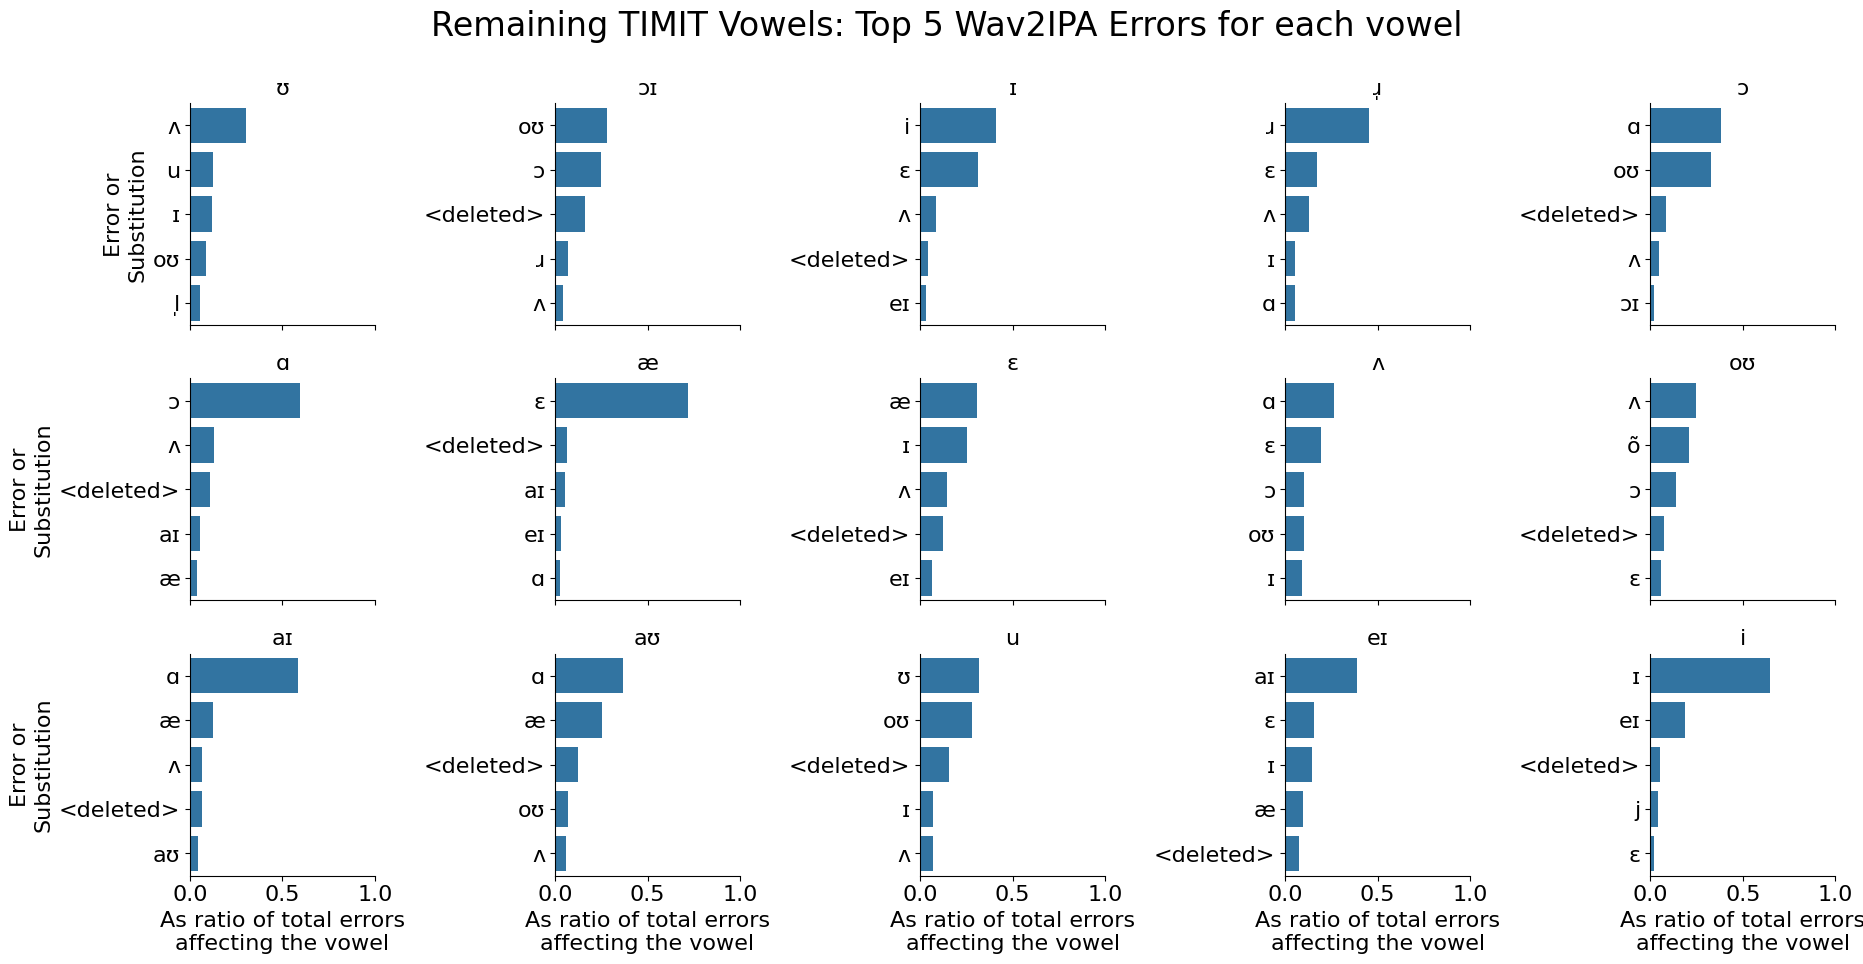

In [24]:
not_convention_errors = [v for v in interesting_vowels if v not in convention_errors]
print(not_convention_errors)
not_convention_errors_df = top_errors_df[top_errors_df["Vowel"].isin(not_convention_errors)]
not_convention_errors_df["Vowel"] = pd.Categorical(
not_convention_errors_df["Vowel"], categories=not_convention_errors, ordered=True
)
display(not_convention_errors_df.head(20))

g = sns.FacetGrid(not_convention_errors_df, col="Vowel", col_wrap=5, sharey=False, aspect=1.25, xlim=(0, 1))
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}", fontsize=20)
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Remaining TIMIT Vowels: Top 5 Wav2IPA Errors for each vowel", fontsize=24, y=1.05)